# Circle Experiments

## Setup

In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
EPSILON = 10 ** -9
def equals_epsilon(a, b):
    return abs(a - b) < EPSILON

## Visualizations (thanks to ChatGPT)

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_points(points, min_x=-10, max_x=10, min_y=-10, max_y=10):
    points = np.array(points)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], color='red', label='Points', zorder=5)
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure square scaling
    plt.show()

def visualize_lines(lines, min_x=-10, max_x=10, min_y=-10, max_y=10):
    plt.figure(figsize=(8, 8))
    
    # Plot each line
    for line in lines:
        # For a line in the form ax + by + c = 0, solve for y = (-ax - c) / b
        x_vals = np.linspace(min_x, max_x, 400)  # x range for plotting
        y_vals = (-line.a * x_vals - line.c) / line.b  # y values from the equation
        
        plt.plot(x_vals, y_vals, label=f'Line: {line}', zorder=5)
    
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure square scaling
    plt.show()

def visualize_points_and_lines(points, lines, min_x=-10, max_x=10, min_y=-10, max_y=10):
    points = np.array(points)
    
    plt.figure(figsize=(8, 8))
    
    # Plot points
    plt.scatter(points[:, 0], points[:, 1], color='red', label='Points', zorder=5)
    
    # Plot each line
    for line in lines:
        x_vals = np.linspace(min_x, max_x, 40000)
        y_vals = (-line.a * x_vals - line.c) / line.b  # y values from the line equation
        
        plt.plot(x_vals, y_vals, label=f'Line: {line}', zorder=5)
    
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')  # Ensure square scaling
    plt.show()


## Underlying model

In [4]:
class Rectangle:
    def __init__(self, width, height, translation=(0, 0), rotation=0):
        self.width = width
        self.height = height
        
        self.translation_vector = np.array(translation)
        
        rotation_rad = np.radians(rotation)
        self.rotation_matrix = np.array([
            [np.cos(rotation_rad), -np.sin(rotation_rad)],
            [np.sin(rotation_rad), np.cos(rotation_rad)]
        ])

    def get_corners(self):
        corners = np.array([
            [-self.width / 2, -self.height / 2],
            [-self.width / 2,  self.height / 2],
            [ self.width / 2, -self.height / 2],
            [ self.width / 2,  self.height / 2]
        ])
        
        return corners @ self.rotation_matrix.T + self.translation_vector

    def area(self):
        return self.width * self.height

    def sample_perimeter_point(self):
        perimeter = 2 * (self.width + self.height)
        prob = random.uniform(0, perimeter)
        
        if prob < 2 * self.width:
            y = random.choice([-self.height / 2, self.height / 2])
            point = np.array([random.uniform(-self.width / 2, self.width / 2), y])
        else:
            x = random.choice([-self.width / 2, self.width / 2])
            point = np.array([x, random.uniform(-self.height / 2, self.height / 2)])
    
        # Apply rotation and translation to the sampled point
        return point @ self.rotation_matrix.T + self.translation_vector

## Experiment Area

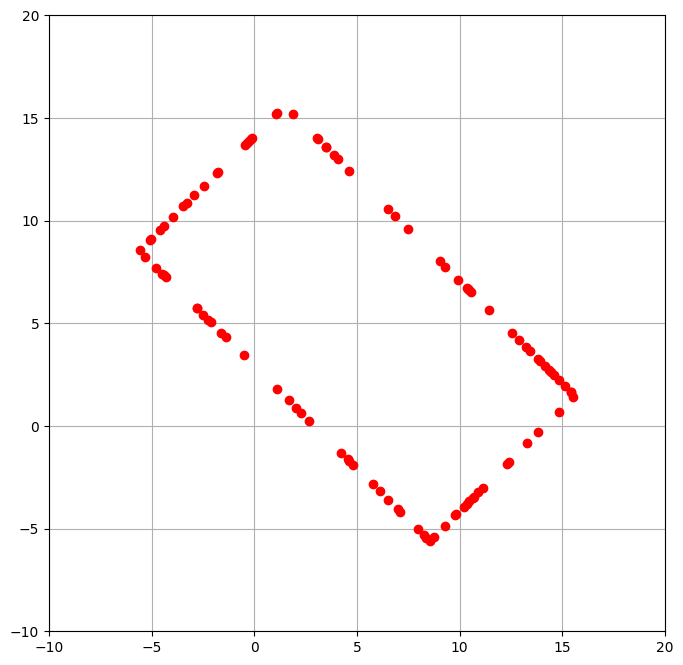

In [5]:
random.seed(69)
r = Rectangle(10, 20, (5, 5), 45)
points = [list(float(c) for c in r.sample_perimeter_point()) for _ in range(100)]
visualize_points(points, -10, 20, -10, 20)

In [6]:
class Line:
    """
    ax + by + c = 0
    ||(a, b)|| = 1
    """

    @staticmethod
    def from_points(p1, p2):
        x1, y1 = p1
        x2, y2 = p2
        
        a = y1 - y2
        b = x2 - x1
        c = x1 * y2 - x2 * y1

        return Line(a, b, c)
    
    def __init__(self, a, b, c):
        norm = math.sqrt(a * a + b * b)
        
        self.a = a / norm
        self.b = b / norm
        self.c = c / norm

    def signed_distance_to_point(self, point):
        return self.a * point[0] + self.b * point[1] + self.c
    
    def __eq__(self, other):
        return equals_epsilon(self.a, other.a) and equals_epsilon(self.b, other.b) and equals_epsilon(self.c, other.c)

    def __repr__(self):
        return f'Line({self.a}, {self.b}, {self.c})'

In [7]:
mu_X = sum(p[0] for p in points) / len(points)
mu_Y = sum(p[1] for p in points) / len(points)
points.sort(key=lambda p: math.atan2(p[1] - mu_Y, p[0] - mu_X))

In [8]:
lines = []
for i in range(-1, len(points) - 1):
    l = Line.from_points(points[i], points[i + 1])
    if l not in lines:
        lines.append(l)
    if len(lines) > 8:
        raise Exception()

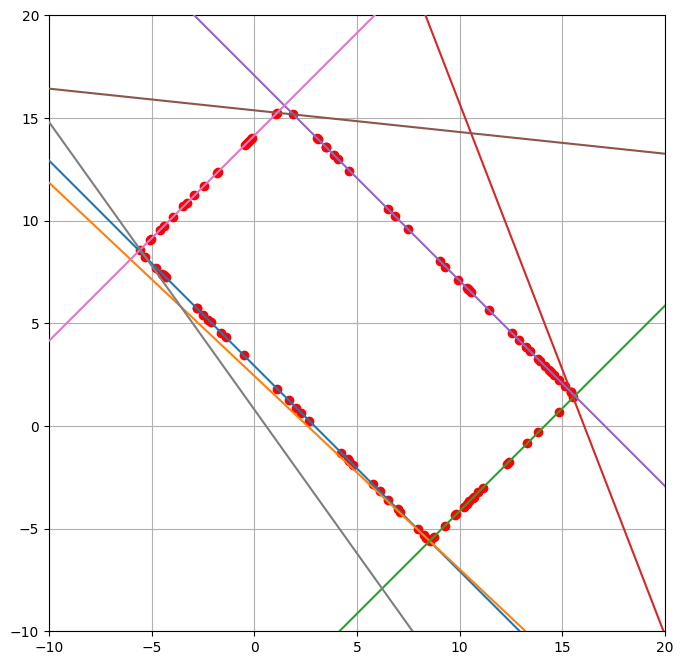

In [9]:
visualize_points_and_lines(points, lines, -10, 20, -10, 20)

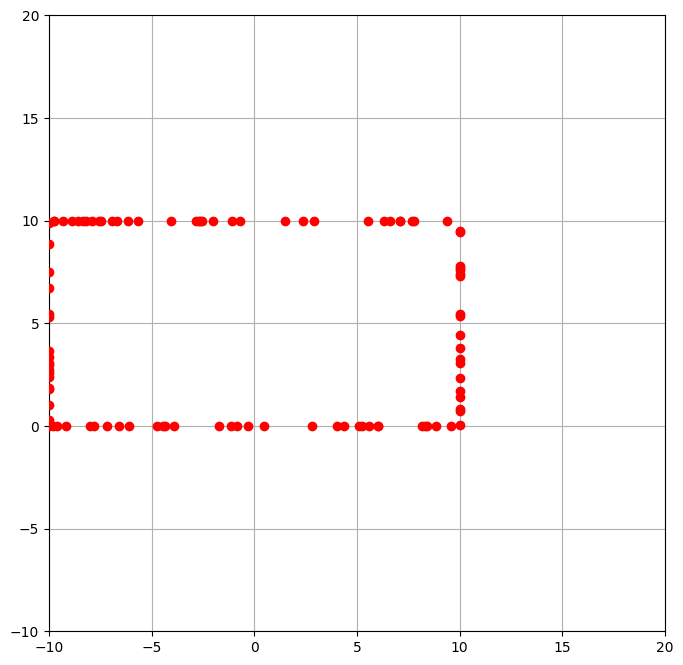

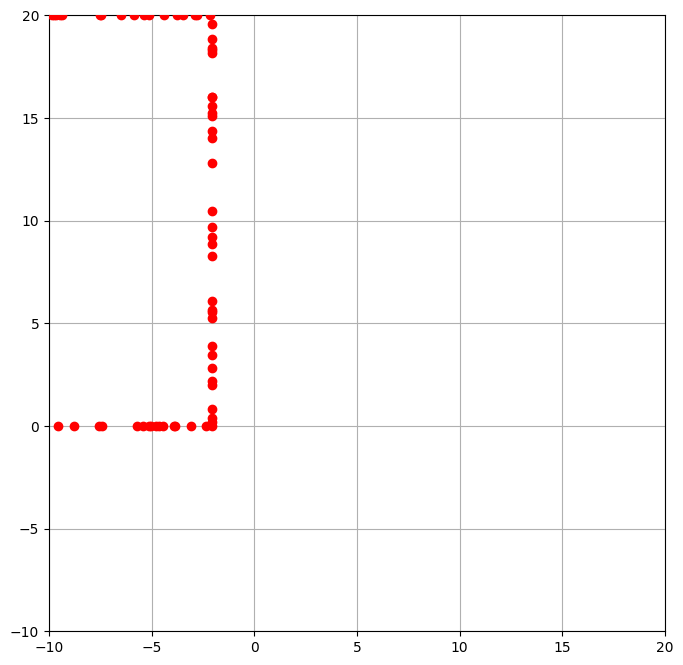

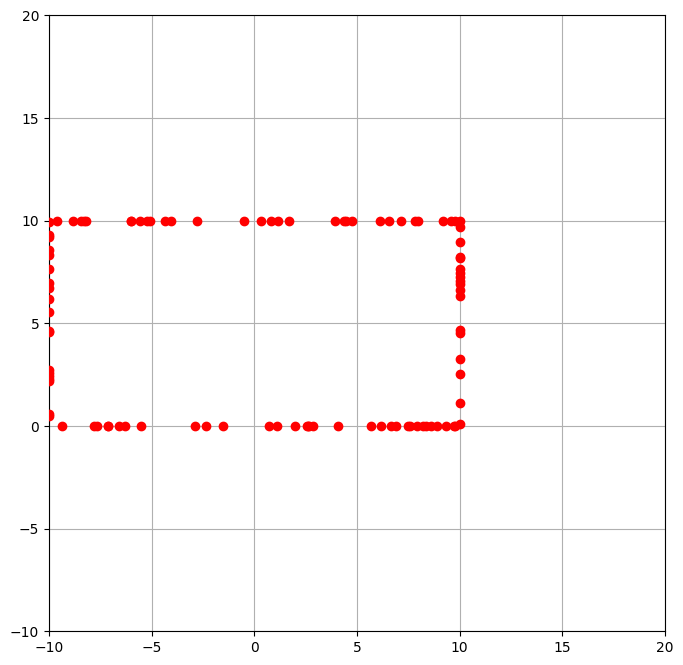

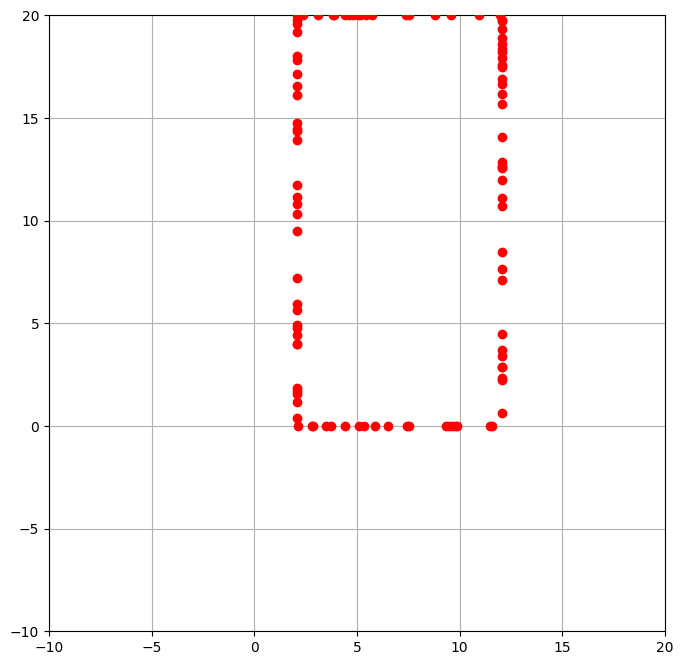

In [10]:
for line in lines:
    new_x_axis = line
    new_y_axis = Line.from_points((0, 0), (new_x_axis.a, new_x_axis.b))
    new_points = [[new_y_axis.signed_distance_to_point(p), new_x_axis.signed_distance_to_point(p)] for p in points]

    new_min_x = min(p[0] for p in new_points)
    new_max_x = max(p[0] for p in new_points)
    new_min_y = min(p[1] for p in new_points)
    new_max_y = max(p[1] for p in new_points)

    if all(equals_epsilon(p[0], new_min_x) or equals_epsilon(p[0], new_max_x) or equals_epsilon(p[1], new_min_y) or equals_epsilon(p[1], new_max_y) for p in new_points):
        visualize_points(new_points, -10, 20, -10, 20)
    

## Putting it all together

In [11]:
def solve(N, X, Y):
    # reorganize as list of points for easier use
    points = list(zip(X, Y))

    # sort radially to be able to collect lines
    mu_X = sum(p[0] for p in points) / N
    mu_Y = sum(p[1] for p in points) / N
    points.sort(key=lambda p: math.atan2(p[1] - mu_Y, p[0] - mu_X))

    # collect lines
    lines = []
    for i in range(-1, N - 1):
        l = Line.from_points(points[i], points[i + 1])
        if l not in lines:
            lines.append(l)

    # sanity check: points are from a rectangle, so we should have at most 4 from sides and 4 from corner cutters
    assert len(lines) <= 8

    # try each line as hypothesis for a side of the rectangle
    for line in lines:
        new_x_axis = line
        new_y_axis = Line.from_points((0, 0), (new_x_axis.a, new_x_axis.b))
        new_points = [[new_y_axis.signed_distance_to_point(p), new_x_axis.signed_distance_to_point(p)] for p in points]

        new_min_x = min(p[0] for p in new_points)
        new_max_x = max(p[0] for p in new_points)
        new_min_y = min(p[1] for p in new_points)
        new_max_y = max(p[1] for p in new_points)

        # if hypothesis works, we have our answer
        if all(equals_epsilon(p[0], new_min_x) or equals_epsilon(p[0], new_max_x) or equals_epsilon(p[1], new_min_y) or equals_epsilon(p[1], new_max_y) for p in new_points):
            return (new_max_x - new_min_x) * (new_max_y - new_min_y)

    # otherwise, we're fucked lmao
    assert False


In [12]:
random.seed(69)
r = Rectangle(10, 20, (5, 5), 45)
points = [list(float(c) for c in r.sample_perimeter_point()) for _ in range(100)]

N = len(points)
X, Y = zip(*points)

solve(N, X, Y)

200.00000000000009

## Making visualizations for sample test cases

In [19]:
def input_string_to_points(input_string):
    return [list(map(float, p.split())) for p in input_string.split('\n')]

In [66]:
def solve_and_visualize(points, min_x=-10, max_x=10, min_y=-10, max_y=10):
    N = len(points)
    
    # sort radially to be able to collect lines
    mu_X = sum(p[0] for p in points) / N
    mu_Y = sum(p[1] for p in points) / N
    points.sort(key=lambda p: math.atan2(p[1] - mu_Y, p[0] - mu_X))

    visualize_points(points, min_x, max_x, min_y, max_y)
    
    # collect lines
    lines = []
    for i in range(-1, N - 1):
        l = Line.from_points(points[i], points[i + 1])
        if l not in lines:
            lines.append(l)

    # sanity check: points are from a rectangle, so we should have at most 4 from sides and 4 from corner cutters
    assert len(lines) <= 8

    # try each line as hypothesis for a side of the rectangle
    for line in lines:
        new_x_axis = line
        new_y_axis = Line.from_points((0, 0), (new_x_axis.a, new_x_axis.b))
        new_points = [[new_y_axis.signed_distance_to_point(p), new_x_axis.signed_distance_to_point(p)] for p in points]

        new_min_x = min(p[0] for p in new_points)
        new_max_x = max(p[0] for p in new_points)
        new_min_y = min(p[1] for p in new_points)
        new_max_y = max(p[1] for p in new_points)

        # if hypothesis works, we have our answer
        if all(equals_epsilon(p[0], new_min_x) or equals_epsilon(p[0], new_max_x) or equals_epsilon(p[1], new_min_y) or equals_epsilon(p[1], new_max_y) for p in new_points):
            
            # visualize_points_and_lines(points, rect_lines, min_x, max_x, min_y, max_y)
            
            return (new_max_x - new_min_x) * (new_max_y - new_min_y)

    # otherwise, we're fucked lmao
    assert False


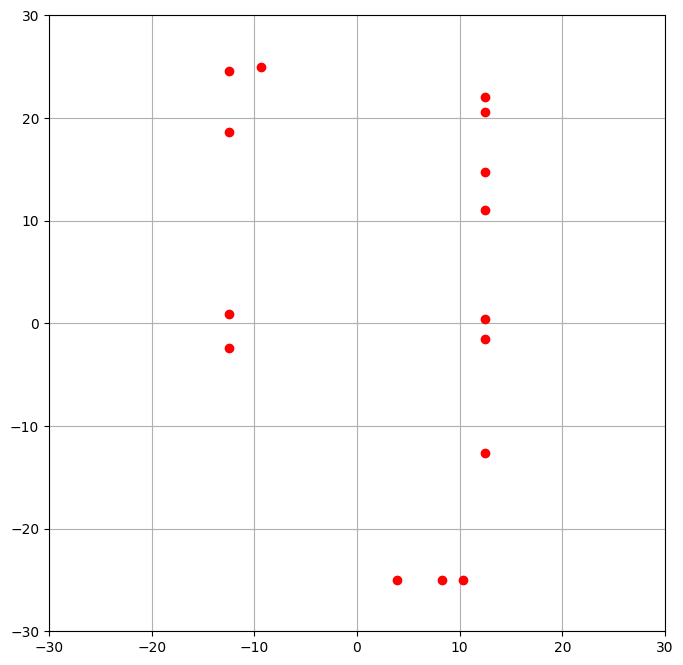

In [69]:
main_sample_input_1 = """-12.5 24.581444432269592
12.5 0.4537699911142603
-12.5 18.588476627459144
12.5 14.694633514413766
3.923470135527239 -25.0
12.5 20.616774349011784
8.289517664266626 -25.0
12.5 -12.605828436346789
12.5 -1.564948928214271
12.5 22.082564741538818
-12.5 0.8719510044145835
12.5 10.990187966325706
10.303290707377279 -25.0
-9.358097673080437 25.0
-12.5 -2.402899199415277"""
points = input_string_to_points(main_sample_input_1)
visualize_points(points, -30, 30, -30, 30)

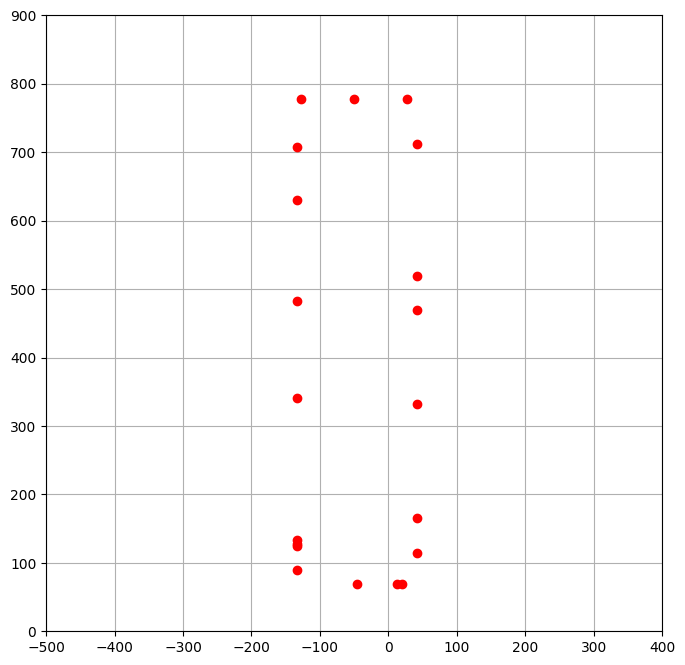

In [36]:
main_sample_input_2 = """-46.25530736081809 69.69
42.42 518.6253330549166
19.798285155211197 69.69
42.42 166.16740057617983
-133.7 708.1933834319171
12.015352617714875 69.69
-133.7 124.38402656309717
42.42 113.98389776041188
-133.7 127.12039996495923
27.324057553634127 777.0
-127.23160199663658 777.0
42.42 712.180391457269
-133.7 133.25526389587543
-133.7 88.84586109158482
-133.7 630.2613964269206
-133.7 482.4189982986889
42.42 332.1704710413993
-50.65893393295834 777.0
-133.7 340.2361267039792
42.42 468.839094040768"""
points = input_string_to_points(main_sample_input_2)
visualize_points(points, -500, 400, 0, 900)

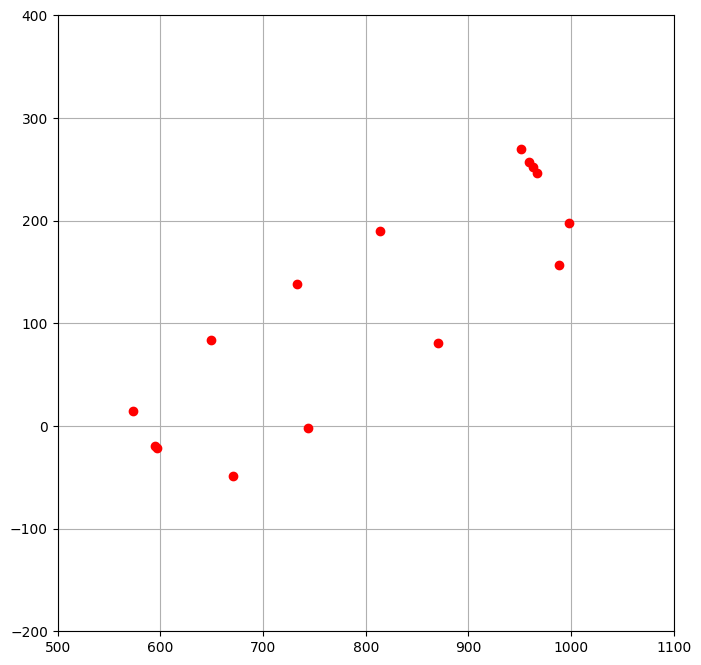

In [41]:
bonus_sample_input = """595.1461537619098 -19.11714267834472
744.004157367241 -1.550984377444749
988.1365165815125 156.99042344152545
733.4063884989355 138.227429067347
596.8428377017889 -21.729806832031457
573.3245789710361 14.485135797381233
966.7642218446249 245.89299156277835
962.570875615006 252.3501785029125
670.7284672650158 -49.13677392661745
870.4130831217591 80.5399318554797
959.4597210937328 257.14093634723446
997.778487690789 198.1352102078391
813.6753242498179 190.35468544185318
951.1889265354808 269.87684311039493
649.6124725858225 83.81102380961775"""
points = input_string_to_points(bonus_sample_input)
visualize_points(points, 500, 1100, -200, 400)